In [ ]:
'''INSTRUCCIONES
1. Carga y exploración de datos:
• Carga el dataset proporcionado, que contiene información sobre la popularidad de distintos
géneros musicales en países como Chile, EE.UU., México, Corea, Japón, Alemania, Rusia e
Italia.
• Analiza las características del dataset, identificando distribuciones y tendencias iniciales.'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler



df= pd.read_csv('C:/Users/natal/Documents/Proyectos data science/M7/dataset_generos_musicales.csv')

print('Primeras filas:')
display(df.head(9))
print('Resumen estadístico:')
display(df.describe())

# Imputación de valores faltantes en variables numéricas
num_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df_num = pd.DataFrame(imputer.fit_transform(df[num_cols]), columns=num_cols)

# Codificación One-Hot de la columna 'Ciudad'
encoder = OneHotEncoder(sparse_output=False)
ciudad_encoded = encoder.fit_transform(df[['País']])
ciudad_df = pd.DataFrame(ciudad_encoded, columns=encoder.get_feature_names_out(['País']))

# Unir variables numéricas y categóricas codificadas
df_imputed = pd.concat([df_num, ciudad_df], axis=1)

# Calcular Q1, Q3 e IQR solo en columnas numéricas originales
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
mask = ~((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any(axis=1)
df_clean = df_imputed[mask].reset_index(drop=True)
print(f'Se eliminaron {len(df_imputed) - len(df_clean)} filas por outliers.')


# Agregar la columna 'País' a df_clean para mantener los nombres originales
df_clean['País'] = df.loc[mask, 'País'].reset_index(drop=True)


# Escalar solo las columnas numéricas y codificadas (excluyendo 'País')
cols_to_scale = df_clean.columns.drop('País')
scaler = StandardScaler()
X_scaler= scaler.fit_transform(df_clean[cols_to_scale])





Primeras filas:


,País,Pop,Rock,Hip-Hop,Electrónica,Clásica,Jazz,Reguetón,Metal
0,Chile,71,22,79,61,70,58,79,69
1,EEUU,34,41,40,79,74,37,90,23
2,México,91,72,52,99,83,23,63,21
3,Corea,80,21,95,34,22,79,27,25
4,Japón,40,49,77,81,70,33,66,73
5,Alemania,94,57,41,81,26,28,54,23
6,Rusia,94,21,68,66,40,72,97,73
7,Italia,43,83,78,81,92,21,55,82


Resumen estadístico:


,Pop,Rock,Hip-Hop,Electrónica,Clásica,Jazz,Reguetón,Metal
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000
mean,68.375000,45.750000,66.250000,72.750000,59.625000,43.875000,66.37500,48.625000
std,25.628876,23.980647,19.912308,19.337233,26.586449,22.680624,22.36028,27.650562
min,34.000000,21.000000,40.000000,34.000000,22.000000,21.000000,27.00000,21.000000
25%,42.250000,21.750000,49.250000,64.750000,36.500000,26.750000,54.75000,23.000000
50%,75.500000,45.000000,72.500000,80.000000,70.000000,35.000000,64.50000,47.000000
75%,91.750000,60.750000,78.250000,81.000000,76.250000,61.500000,81.75000,73.000000
max,94.000000,83.000000,95.000000,99.000000,92.000000,79.000000,97.00000,82.000000


Se eliminaron 1 filas por outliers.


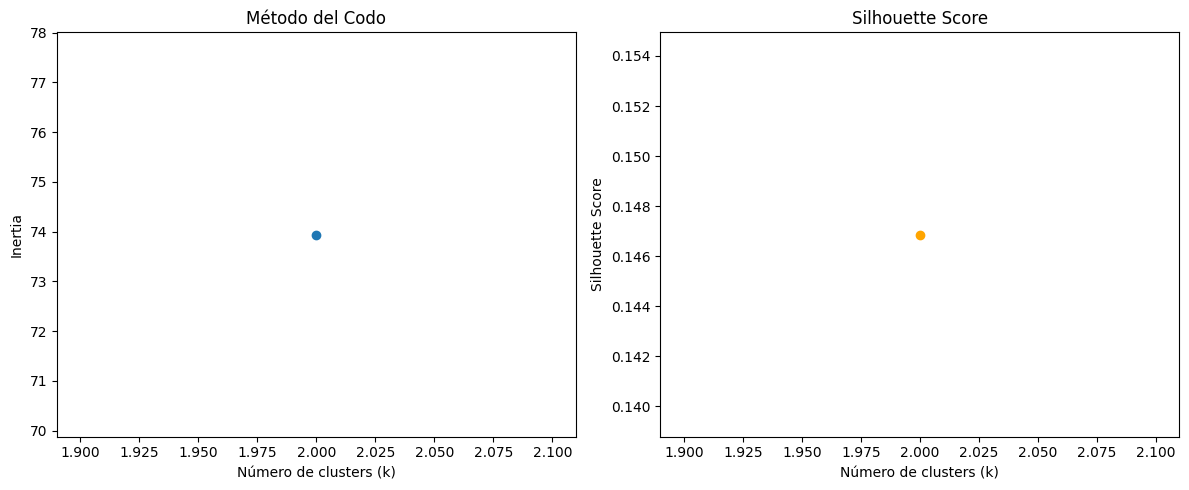

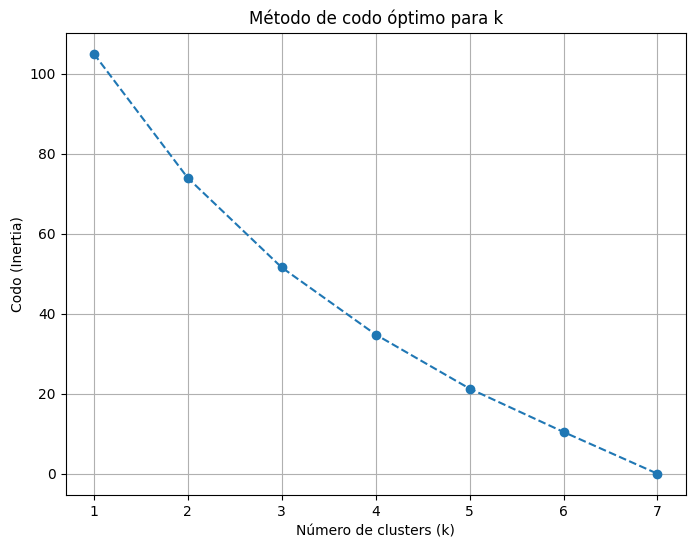

Mejor k por Silhouette Score: 2 (score=0.147)


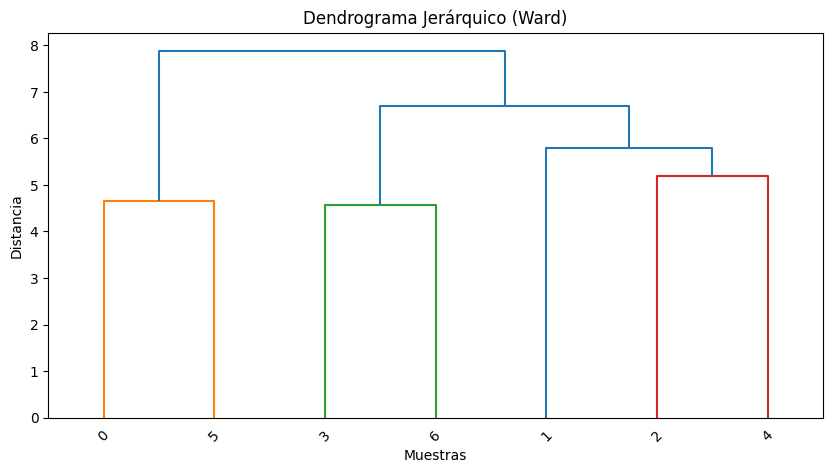

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

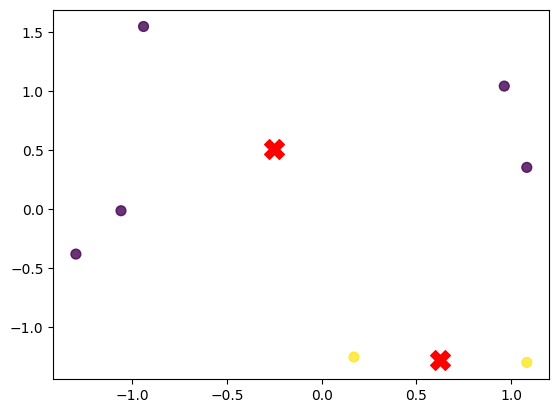

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

'''2. Aplicación de algoritmos de clusterización:
K-Means:
• Aplica el algoritmo K-Means con un valor inicial de K=3.
• Determina el valor óptimo de K utilizando el método del codo y el coeficiente de silueta.
Clustering jerárquico:
• Genera un dendrograma y determina el número óptimo de clusters.'''

#Silueta

inertia = []
sil_scores = []
K = range(2, 3)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaler)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaler, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()


#Método del codo

codo = []


for i in range(1, 8): # Test k from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=8)
    kmeans.fit(X_scaler)
    codo.append(kmeans.inertia_)



plt.figure(figsize=(8, 6))
plt.plot(range(1, 8), codo, marker='o', linestyle='--')
plt.title('Método de codo óptimo para k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Codo (Inertia)')
plt.grid(True)
plt.show()

#Método de silueta

def select_k_silhouette(K, sil_scores):
    best_index = np.argmax(sil_scores)
    return K[best_index], sil_scores[best_index]

k_sil, score_sil = select_k_silhouette(list(K), sil_scores)
print(f'Mejor k por Silhouette Score: {k_sil} (score={score_sil:.3f})')

#Dendrograma

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

linked = linkage(X_scaler, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=45, leaf_font_size=10, show_contracted=True)
plt.title('Dendrograma Jerárquico (Ward)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()


#K-Means óptimo

optimal_k = 2  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaler)
df_clean['cluster_kmeans'] = clusters_kmeans
df_clean.loc[:, 'cluster_kmeans'] = clusters_kmeans

# Obtención de labels y centroides

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# gráfico
plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='X', color='red', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Países')
plt.ylabel('Géneros musicales')
plt.legend()
plt.grid(True)
plt.show()


'''• Aplica clustering jerárquico y compara con los resultados de K-Means.
DBSCAN:
• Aplica DBSCAN con diferentes valores de eps y MinPts.
• Justifica la elección de los parámetros y analiza si DBSCAN identifica agrupaciones
significativas.'''

from sklearn.cluster import DBSCAN

#DBSCAN 1

dbscan1 = DBSCAN(eps=2, min_samples=4) #---> Usando el k distance sugerido y asumiento que los datos son 2D
clusters_dbscan = dbscan1.fit_predict(X_scaler)
print("Cluster labels 1:", clusters_dbscan)
labels = dbscan1.labels_

# Gráfico

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:  # Noise points
        col = [0, 0, 0, 1] # Black for noise

    class_member_mask = (labels == k)

    xy = X_scaler[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.xlabel('Países')
plt.ylabel('Géneros musicales')
plt.show()


#DBSCAN 2

dbscan2 = DBSCAN(eps=5.5, min_samples=5) #---> Siguiendo la distancia sugerida por el dendrograma
clusters_dbscan2 = dbscan2.fit_predict(X_scaler)
print("Cluster labels 2:", clusters_dbscan2)

# Gráfico
labels = dbscan2.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:  # Noise points
        col = [0, 0, 0, 1] # Black for noise

    class_member_mask = (labels == k)

    xy = X_scaler[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.xlabel('Países')
plt.ylabel('Géneros musicales')
plt.show()


#DBSCAN 3

dbscan3 = DBSCAN(eps=2, min_samples=5) #----> Los últimos dos son solo intercambios para experimentar
clusters_dbscan3 = dbscan3.fit_predict(X_scaler)
print("Cluster labels 3:", clusters_dbscan3)

# Gráfico
labels = dbscan3.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:  # Noise points
        col = [0, 0, 0, 1] # Black for noise

    class_member_mask = (labels == k)

    xy = X_scaler[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.xlabel('Países')
plt.ylabel('Géneros musicales')
plt.show()


#DBSCAN 4
dbscan4 = DBSCAN(eps=5.5, min_samples=4)
clusters_dbscan4 = dbscan4.fit_predict(X_scaler)
print("Cluster labels 4:", clusters_dbscan4)

# Gráfico
labels = dbscan4.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:  # Noise points
        col = [0, 0, 0, 1] # Black for noise

    class_member_mask = (labels == k)

    xy = X_scaler[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.xlabel('Países')
plt.ylabel('Géneros musicales')
plt.show()



Varianza explicada por cada componente: [0.33256372 0.2363468 ]


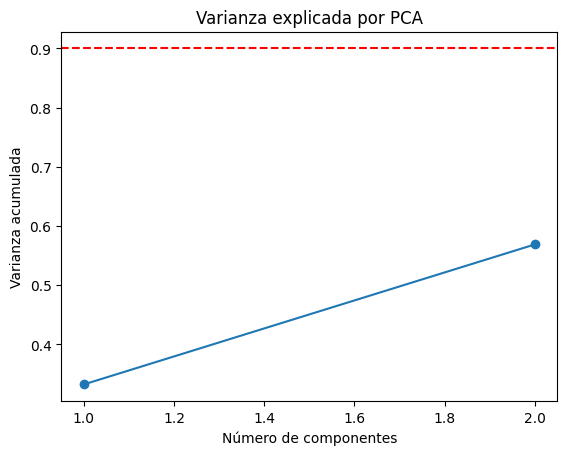

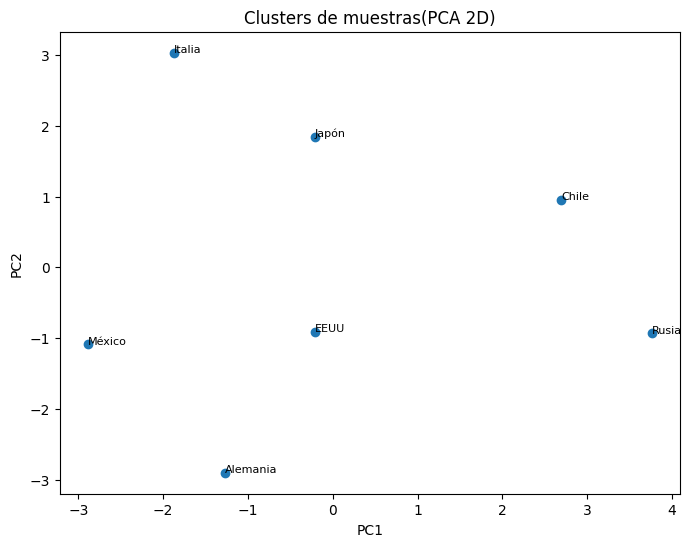

C:\Users\natal\AppData\Local\Temp\ipykernel_10564\3223461064.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


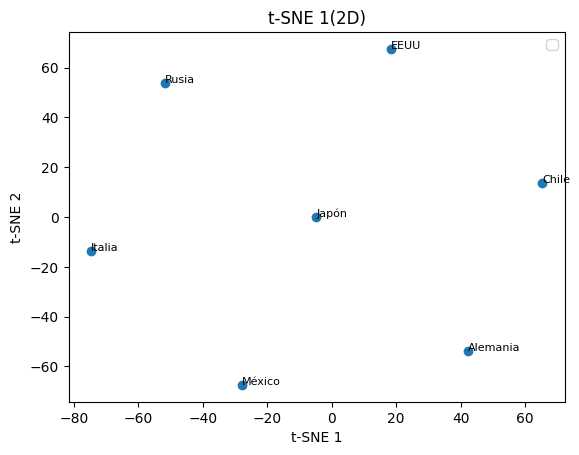

C:\Users\natal\AppData\Local\Temp\ipykernel_10564\3223461064.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


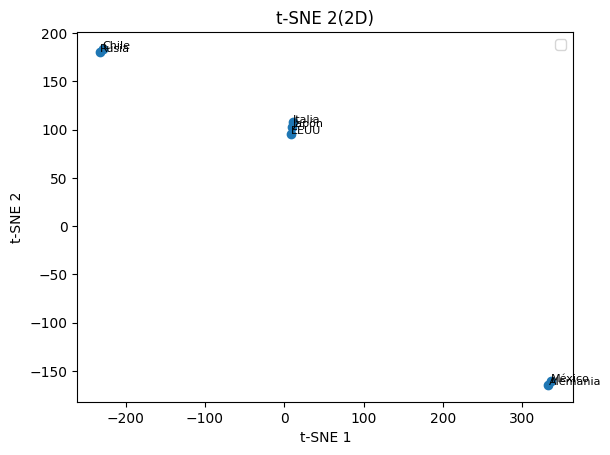

C:\Users\natal\AppData\Local\Temp\ipykernel_10564\3223461064.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


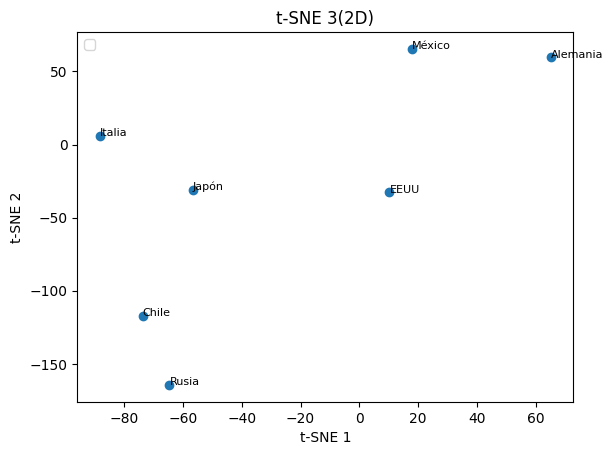

In [ ]:
from sklearn.decomposition import PCA

'''3. Aplicación de reducción de dimensionalidad:
PCA:
• Aplica PCA y determina cuántos componentes principales explican al menos el 90% de la
varianza.
• Visualiza los países en un gráfico bidimensional con las primeras dos componentes
principales.
t-SNE:
• Aplica t-SNE para visualizar la relación entre los países en un espacio de 2D.
• Experimenta con diferentes valores de perplexity y analiza cómo afectan la representación.'''

#PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaler)
var_exp = np.cumsum(pca.explained_variance_ratio_)
print('Varianza explicada por cada componente:', pca.explained_variance_ratio_)
plt.plot(range(1, len(var_exp)+1), var_exp, marker='o')
plt.axhline(0.9, color='r', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza explicada por PCA')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
for i, ciudad in enumerate(df_clean['País']):
    plt.text(X_pca[i,0], X_pca[i,1], ciudad, fontsize=8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters de muestras(PCA 2D)')
plt.show()


#t-SNE1

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=6)
X_tsne1 = tsne.fit_transform(X_scaler)

plt.scatter(X_tsne1[:,0], X_tsne1[:,1])
for i, ciudad in enumerate(df_clean['País']):
    plt.text(X_tsne1[i,0], X_tsne1[i,1], ciudad, fontsize=8)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE 1(2D)')
plt.legend()
plt.show()

#t-SNE2

tsne = TSNE(n_components=2, random_state=42, perplexity=1)
X_tsne2 = tsne.fit_transform(X_scaler)

plt.scatter(X_tsne2[:,0], X_tsne2[:,1])
for i, ciudad in enumerate(df_clean['País']):
    plt.text(X_tsne2[i,0], X_tsne2[i,1], ciudad, fontsize=8)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE 2(2D)')
plt.legend()
plt.show()

#t-SNE3

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
X_tsne3 = tsne.fit_transform(X_scaler)

plt.scatter(X_tsne3[:,0], X_tsne3[:,1])
for i, ciudad in enumerate(df_clean['País']):
    plt.text(X_tsne3[i,0], X_tsne3[i,1], ciudad, fontsize=8)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE 3(2D)')
plt.legend()
plt.show()

